In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pylab import mpl
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]

In [2]:
from data_utils import data_reader

data_path = './data'
data_file = "治疗过程记录.xlsx"
output_path = './outputs'


### 读数据

In [3]:
time_path = os.path.join(output_path,"time_factor.csv")
time_factor_df = pd.read_csv(time_path)

### 预处理性别年龄

In [4]:
# data = data_reader(data_path,data_file)
# gender_df = data[['mr_bah','mr_xb','mr_nn']]
# gender_df = gender_df.drop_duplicates()
# gender_df['mr_nn'] = gender_df['mr_nn'].str.extract('(\d+)').astype(int)
# gender_df['mr_xb'] = gender_df['mr_xb'].astype(int)
# gender_df.to_csv(f"{output_path}/gender.csv",index=False)

gender_df = pd.read_csv(f"{output_path}/gender.csv")
gender_df

,mr_bah,mr_xb,mr_nn
0,L0001110255,1,55
1,L0001106901,1,60
2,L0001118051,1,56
3,L0001121508,1,62
4,L0001123366,2,58
...,...,...,...
186,L0001182434,1,59
187,L0001184723,2,44
188,L0001185049,2,51
189,L0001185394,2,56


### 数据检验

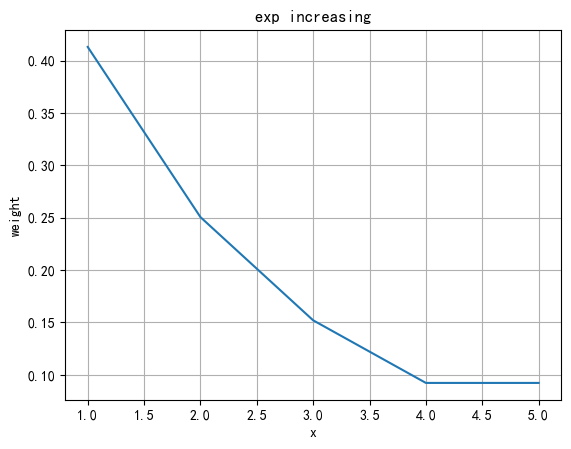

In [5]:
def weighted_exp_decreasing_mean(series,axis=0,alpha=0.5,thresh_hold=4, plot=False):
    alpha = alpha

    x = np.linspace(1, len(series), len(series))

#     y = np.exp(-alpha * x) / ((1/alpha) * np.exp(-alpha * x[-1]))
#     y = (1-np.exp(-alpha * x)) / (1-np.exp(-alpha * x)).sum()

    exp = (np.exp(-alpha * x))
    y = exp
    
    if len(exp) > thresh_hold:
        y[thresh_hold:] = exp[thresh_hold-1]
    
    y = y / y.sum()
    
    if plot:
        plt.plot(x, y)
        plt.title('exp increasing')
        plt.xlabel('x')
        plt.ylabel('weight')
        plt.grid(True)
        plt.show()
    else:
        if len(series.shape) > 1:
            out = (np.expand_dims(y,-1) * series)
        else:
            out = (y * series)
        return out.sum(axis=axis)
weighted_exp_decreasing_mean(np.zeros((5,10)),plot=True)

#### 对时间序列求指数平均

In [6]:
df_regular = time_factor_df[time_factor_df['脑脊液常规(检)-凝固性'] !=0]
df_bio = time_factor_df[time_factor_df['脑脊液常规(检)-凝固性'] ==0]
admission_num = pd.unique(time_factor_df['mr_bah'])

In [7]:
def series_splitter(df,mr_bah,window_size,mean_method=np.mean,fill_inf=0):
    num_features = df.shape[-1] - 2
    
    series_matrix = np.zeros((len(mr_bah),window_size,num_features))
    
    for i,mr_bah_no in enumerate(mr_bah):
        mask = (df['mr_bah'] == mr_bah_no)
        to_split_matrix = df[mask].to_numpy()[:,2:].astype(np.float32)
        
        series_len = to_split_matrix.shape[0]
        to_split_matrix[np.isinf(to_split_matrix)] = fill_inf
        if series_len <= window_size:
            series_matrix[i,:series_len] = to_split_matrix
            series_matrix[i,series_len:] = to_split_matrix[-1]
        else:
            offset = series_len//window_size
            step = window_size
            for j in range(0,step,offset):
                series_matrix[i,j] = mean_method(to_split_matrix[j:j+offset],axis=0)
        
    series_matrix = series_matrix.reshape(len(mr_bah),window_size*num_features)
    _colnames = df.columns[-num_features:]
    
    colnames = np.concatenate([_colnames+f"-time-{i}" for i in range(window_size)])
    
    return_df = pd.DataFrame(series_matrix,columns=colnames,index=mr_bah)
    return_df.index.name = 'mr_bah'
    return return_df

In [8]:
regular_matrix = series_splitter(df_regular,admission_num,5,
#                                  mean_method=weighted_exp_decreasing_mean,
                                 fill_inf=-1e2)
bio_matrix = series_splitter(df_bio,admission_num,5,
#                              mean_method=weighted_exp_decreasing_mean,
                             fill_inf=-1e2)

In [9]:
quantize_matrix = regular_matrix + bio_matrix
quantize_matrix

,脑脊液常规(检)-凝固性-time-0,脑脊液常规(检)-多个核细胞百分比-time-0,脑脊液常规(检)-微量蛋白[MTP]-time-0,脑脊液常规(检)-氯[CL]-time-0,脑脊液常规(检)-白细胞计数-time-0,脑脊液常规(检)-葡萄糖[Glu]-time-0,脑脊液常规(检)-蛋白定性-time-0,脑脊液常规(检)-透明度-time-0,脑脊液生化(检)-凝固性-time-0,脑脊液生化(检)-多个核细胞百分比-time-0,...,脑脊液生化(检)-蛋白定性-time-4,脑脊液生化(检)-透明度-time-4,脑脊液细胞学检查(检)-凝固性-time-4,脑脊液细胞学检查(检)-多个核细胞百分比-time-4,脑脊液细胞学检查(检)-微量蛋白[MTP]-time-4,脑脊液细胞学检查(检)-氯[CL]-time-4,脑脊液细胞学检查(检)-白细胞计数-time-4,脑脊液细胞学检查(检)-葡萄糖[Glu]-time-4,脑脊液细胞学检查(检)-蛋白定性-time-4,脑脊液细胞学检查(检)-透明度-time-4
mr_bah,,,,,,,,,,,,,,,,,,,,,
L0000900097,245.0,92.0,0.0,0.0,272.0,0.0,248.0,243.0,0.0,0.0,...,0.0,0.0,245.0,25.0,0.0,0.0,138.0,0.0,248.0,242.0
L0000903157,245.0,55.0,0.0,0.0,33.0,0.0,249.0,244.0,0.0,0.0,...,0.0,0.0,245.0,6.0,0.0,0.0,19.0,0.0,248.0,242.0
L0000996807,245.0,-100.0,0.0,0.0,1.0,0.0,248.0,242.0,0.0,0.0,...,0.0,0.0,245.0,16.0,0.0,0.0,45.0,0.0,248.0,242.0
L0001018730,245.0,-100.0,0.0,0.0,1.0,0.0,248.0,242.0,0.0,0.0,...,0.0,0.0,245.0,2.0,0.0,0.0,53.0,0.0,249.0,242.0
L0001028637,245.0,98.0,0.0,0.0,3206.0,0.0,250.0,243.0,0.0,0.0,...,0.0,0.0,245.0,7.0,0.0,0.0,41.0,0.0,248.0,242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L0001182434,245.0,58.0,0.0,0.0,34.0,0.0,248.0,243.0,0.0,0.0,...,0.0,0.0,245.0,14.0,0.0,0.0,29.0,0.0,248.0,242.0
L0001184723,245.0,49.0,0.0,0.0,27.0,0.0,248.0,243.0,0.0,0.0,...,0.0,0.0,245.0,6.0,0.0,0.0,20.0,0.0,248.0,242.0
L0001185049,245.0,86.0,0.0,0.0,61.0,0.0,248.0,244.0,0.0,0.0,...,0.0,0.0,245.0,86.0,0.0,0.0,61.0,0.0,248.0,244.0


In [10]:
quantize_matrix.shape

(191, 120)

#### 选择非空列

In [11]:
zero_mask = quantize_matrix.to_numpy().sum(0) != 0
selected_columns = quantize_matrix.columns[zero_mask]
selected_columns

Index(['脑脊液常规(检)-凝固性-time-0', '脑脊液常规(检)-多个核细胞百分比-time-0',
       '脑脊液常规(检)-白细胞计数-time-0', '脑脊液常规(检)-蛋白定性-time-0', '脑脊液常规(检)-透明度-time-0',
       '脑脊液生化(检)-微量蛋白[MTP]-time-0', '脑脊液生化(检)-氯[CL]-time-0',
       '脑脊液生化(检)-葡萄糖[Glu]-time-0', '脑脊液细胞学检查(检)-凝固性-time-0',
       '脑脊液细胞学检查(检)-多个核细胞百分比-time-0', '脑脊液细胞学检查(检)-白细胞计数-time-0',
       '脑脊液细胞学检查(检)-蛋白定性-time-0', '脑脊液细胞学检查(检)-透明度-time-0',
       '脑脊液常规(检)-凝固性-time-1', '脑脊液常规(检)-多个核细胞百分比-time-1',
       '脑脊液常规(检)-白细胞计数-time-1', '脑脊液常规(检)-蛋白定性-time-1', '脑脊液常规(检)-透明度-time-1',
       '脑脊液生化(检)-微量蛋白[MTP]-time-1', '脑脊液生化(检)-氯[CL]-time-1',
       '脑脊液生化(检)-葡萄糖[Glu]-time-1', '脑脊液细胞学检查(检)-凝固性-time-1',
       '脑脊液细胞学检查(检)-多个核细胞百分比-time-1', '脑脊液细胞学检查(检)-白细胞计数-time-1',
       '脑脊液细胞学检查(检)-蛋白定性-time-1', '脑脊液细胞学检查(检)-透明度-time-1',
       '脑脊液常规(检)-凝固性-time-2', '脑脊液常规(检)-多个核细胞百分比-time-2',
       '脑脊液常规(检)-白细胞计数-time-2', '脑脊液常规(检)-蛋白定性-time-2', '脑脊液常规(检)-透明度-time-2',
       '脑脊液生化(检)-微量蛋白[MTP]-time-2', '脑脊液生化(检)-氯[CL]-time-2',
       '脑脊液生化(检)-葡萄糖[Glu]-time-2

In [12]:
quantize_matrix = quantize_matrix[selected_columns]
quantize_matrix

,脑脊液常规(检)-凝固性-time-0,脑脊液常规(检)-多个核细胞百分比-time-0,脑脊液常规(检)-白细胞计数-time-0,脑脊液常规(检)-蛋白定性-time-0,脑脊液常规(检)-透明度-time-0,脑脊液生化(检)-微量蛋白[MTP]-time-0,脑脊液生化(检)-氯[CL]-time-0,脑脊液生化(检)-葡萄糖[Glu]-time-0,脑脊液细胞学检查(检)-凝固性-time-0,脑脊液细胞学检查(检)-多个核细胞百分比-time-0,...,脑脊液常规(检)-蛋白定性-time-4,脑脊液常规(检)-透明度-time-4,脑脊液生化(检)-微量蛋白[MTP]-time-4,脑脊液生化(检)-氯[CL]-time-4,脑脊液生化(检)-葡萄糖[Glu]-time-4,脑脊液细胞学检查(检)-凝固性-time-4,脑脊液细胞学检查(检)-多个核细胞百分比-time-4,脑脊液细胞学检查(检)-白细胞计数-time-4,脑脊液细胞学检查(检)-蛋白定性-time-4,脑脊液细胞学检查(检)-透明度-time-4
mr_bah,,,,,,,,,,,,,,,,,,,,,
L0000900097,245.0,92.0,272.0,248.0,243.0,0.91,122.800003,4.06,245.0,92.0,...,248.0,242.0,1.31,124.500000,2.76,245.0,25.0,138.0,248.0,242.0
L0000903157,245.0,55.0,33.0,249.0,244.0,1.77,119.199997,4.06,245.0,55.0,...,248.0,242.0,1.03,124.099998,2.87,245.0,6.0,19.0,248.0,242.0
L0000996807,245.0,-100.0,1.0,248.0,242.0,0.36,128.100006,4.94,245.0,-100.0,...,248.0,242.0,0.67,121.099998,2.78,245.0,16.0,45.0,248.0,242.0
L0001018730,245.0,-100.0,1.0,248.0,242.0,0.30,128.500000,3.15,245.0,-100.0,...,249.0,242.0,0.68,124.699997,2.92,245.0,2.0,53.0,249.0,242.0
L0001028637,245.0,98.0,3206.0,250.0,243.0,4.41,111.000000,4.23,245.0,98.0,...,248.0,242.0,1.51,122.199997,3.50,245.0,7.0,41.0,248.0,242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
L0001182434,245.0,58.0,34.0,248.0,243.0,0.53,127.000000,3.39,245.0,58.0,...,248.0,242.0,0.58,123.500000,3.13,245.0,14.0,29.0,248.0,242.0
L0001184723,245.0,49.0,27.0,248.0,243.0,0.43,123.099998,2.81,245.0,49.0,...,248.0,242.0,0.38,122.400002,2.58,245.0,6.0,20.0,248.0,242.0
L0001185049,245.0,86.0,61.0,248.0,244.0,2.31,108.900002,8.31,245.0,86.0,...,248.0,244.0,2.31,108.900002,8.31,245.0,86.0,61.0,248.0,244.0


In [13]:
quantize_matrix.shape

(191, 65)

#### 读入病症onehot

In [14]:
onehot_path = os.path.join(output_path,"onehot_illness.csv")
onehot_illness = pd.read_csv(onehot_path)
onehot_illness = onehot_illness.drop(columns=['颅内感染'])

selected_columns = ['低钠血症', '外展神经损伤', '多发性大脑挫裂伤', '手术后切口愈合不良', '脑实质出血继发蛛网膜下腔出血','脑室腹腔分流管置入感染']
# onehot_illness = onehot_illness[selected_columns+['mr_bah']]
onehot_illness

,mr_bah,胸腔积液,肺部感染,脑水肿,高血压病3级（极高危）,面肌痉挛,电解质紊乱,三叉神经痛,颅内动脉瘤破裂伴蛛网膜下腔出血,肺气肿,...,子宫腺肌瘤,椎间盘突出,共济失调,肺良性肿瘤,大脑动脉狭窄脑梗死,癫痫大发作状态,弥漫性颅内压增高,冠状动脉支架植入后状态,急性前间壁心肌梗死,肺原位癌
0,L0001110255,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,L0001106901,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,L0001118051,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,L0001121508,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,L0001123366,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,L0001182434,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
187,L0001184723,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
188,L0001185049,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
189,L0001185394,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 读入手术onehot

In [15]:
onehot_path = os.path.join(output_path,"onehot_op.csv")
onehot_op = pd.read_csv(onehot_path)

target = onehot_op['颅内感染']
onehot_op = onehot_op.drop(columns=['颅内感染'])

selected_columns = ['侧脑室脑池造口引流术', '后颅窝病损切除术', '脑室Ommaya泵置入术', '脑室分流管去除术']
# onehot_op = onehot_op[selected_columns+['mr_bah']]
onehot_op

,mr_bah,腰椎穿刺术,脑血管造影,硬脑膜补片修补术,颅骨去骨瓣减压术,脑内血肿清除术,内镜下面神经微血管减压术,脑室钻孔引流术,内镜下三叉神经微血管减压术,腰大池引流术,...,脊髓病损切除术,胸腔镜下肺楔形切除术,胸腔闭式引流术,骨盆骨折切开复位钢板内固定术,皮肤和皮下坏死组织切除清创术,大脑中动脉（MCA分叉部）动脉瘤栓塞术（AN）,硬脑膜外切开引流术,额叶切除术,冠状动脉CT血管显像,面神经微血管减压术
0,L0001110255,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,L0001106901,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,L0001118051,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,L0001121508,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,L0001123366,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,L0001182434,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
187,L0001184723,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
188,L0001185049,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
189,L0001185394,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 形成最终data

In [16]:
data_df = pd.merge(onehot_op,onehot_illness,on='mr_bah')
data_df = pd.merge(data_df,gender_df,on='mr_bah')
data_df = pd.merge(data_df,quantize_matrix,on='mr_bah')
try:
    data_df = data_df.drop(columns=['颅内感染'])
except: None
data_df = data_df.drop(columns=['mr_bah'])
data_df

,腰椎穿刺术,脑血管造影,硬脑膜补片修补术,颅骨去骨瓣减压术,脑内血肿清除术,内镜下面神经微血管减压术,脑室钻孔引流术,内镜下三叉神经微血管减压术,腰大池引流术,头部CT检查,...,脑脊液常规(检)-蛋白定性-time-4,脑脊液常规(检)-透明度-time-4,脑脊液生化(检)-微量蛋白[MTP]-time-4,脑脊液生化(检)-氯[CL]-time-4,脑脊液生化(检)-葡萄糖[Glu]-time-4,脑脊液细胞学检查(检)-凝固性-time-4,脑脊液细胞学检查(检)-多个核细胞百分比-time-4,脑脊液细胞学检查(检)-白细胞计数-time-4,脑脊液细胞学检查(检)-蛋白定性-time-4,脑脊液细胞学检查(检)-透明度-time-4
0,0,0,1,1,1,0,0,0,0,0,...,248.5,242.5,0.695,76.500000,1.305,245.0,-5.0,609.5,248.5,242.5
1,1,0,0,0,0,0,0,0,1,0,...,250.0,244.0,6.310,107.099998,2.440,245.0,18.0,139.0,250.0,244.0
2,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.000,0.000000,0.000,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.000,0.000000,0.000,0.0,0.0,0.0,0.0,0.0
4,0,0,1,0,0,0,0,0,0,0,...,248.0,242.0,0.650,132.399994,3.620,245.0,-100.0,6.0,248.0,242.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,0,0,0,0,0,0,0,1,0,0,...,248.0,242.0,0.580,123.500000,3.130,245.0,14.0,29.0,248.0,242.0
187,0,1,0,0,0,0,0,0,0,0,...,248.0,242.0,0.380,122.400002,2.580,245.0,6.0,20.0,248.0,242.0
188,0,0,0,0,0,0,0,0,0,0,...,248.0,244.0,2.310,108.900002,8.310,245.0,86.0,61.0,248.0,244.0
189,0,0,0,0,1,0,1,0,0,0,...,250.0,244.0,2.540,122.099998,2.850,245.0,51.0,265.0,250.0,244.0


In [17]:
target.shape

(191,)

In [18]:
data_df.shape

(191, 509)

## 训练

### 决策森林

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 示例数据（替换为你的实际数据）
X = data_df.to_numpy().astype(np.float32)  # 训练数据
y = target.to_numpy().astype(np.float32)  # 二分类目标

# 数据分割为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# 数据标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# 定义随机森林分类器
rf = RandomForestClassifier(random_state=42)

# 定义参数网格
param_grid = {
    'n_estimators': [50, 100],  # 树的数量
    'max_depth': [None, 10],  # 树的最大深度
    'min_samples_split': [5, 10],  # 分裂节点的最小样本数
    'min_samples_leaf': [1, 2],  # 叶子节点的最小样本数
    'max_features': [ 'sqrt', 'log2']  # 最大特征数
}

# 交叉验证
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("Best Parameters:", grid_search.best_params_)

# 使用最佳参数进行预测
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [25]:


from sklearn.model_selection import cross_val_score, KFold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
scores = cross_val_score(best_rf, X, y, cv=kf)

print(f"Cross-validation scores: {scores}")
print(f"Mean score: {np.mean(scores)}")
print(f"Standard deviation of scores: {np.std(scores)}")

splits = list(kf.split(X))
idx = 2
best_rf.fit(X[splits[idx][0]], y[splits[idx][0]])
y_pred_best_rf = best_rf.predict(X[splits[idx][1]])
print("Random Forest Best Model Accuracy:", accuracy_score(y[splits[idx][1]], y_pred_best_rf))
y_train_best_rf = best_rf.predict(X[splits[idx][0]])
print("Random Forest Best Train Accuracy:", accuracy_score(y[splits[idx][0]], y_train_best_rf))

print("Random Forest Report:\n", )
print(classification_report(y[splits[idx][1]], y_pred_best_rf))
print("Confusion Matrix:\n", )
print(confusion_matrix(y[splits[idx][1]], y_pred_best_rf))

Cross-validation scores: [0.8974359  0.76315789 0.84210526 0.89473684 0.78947368]
Mean score: 0.8373819163292847
Standard deviation of scores: 0.054263767375450356
Random Forest Best Model Accuracy: 0.8421052631578947
Random Forest Best Train Accuracy: 0.9477124183006536
Random Forest Report:

              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91        30
         1.0       0.75      0.38      0.50         8

    accuracy                           0.84        38
   macro avg       0.80      0.67      0.70        38
weighted avg       0.83      0.84      0.82        38

Confusion Matrix:

[[29  1]
 [ 5  3]]


C:\Users\hasaki\miniconda3\envs\DL\lib\site-packages\shap\plots\_beeswarm.py:962: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  pl.tight_layout()
C:\Users\hasaki\miniconda3\envs\DL\lib\site-packages\shap\plots\_beeswarm.py:962: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
C:\Users\hasaki\miniconda3\envs\DL\lib\site-packages\shap\plots\_beeswarm.py:636: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)
C:\Users\hasaki\miniconda3\envs\DL\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


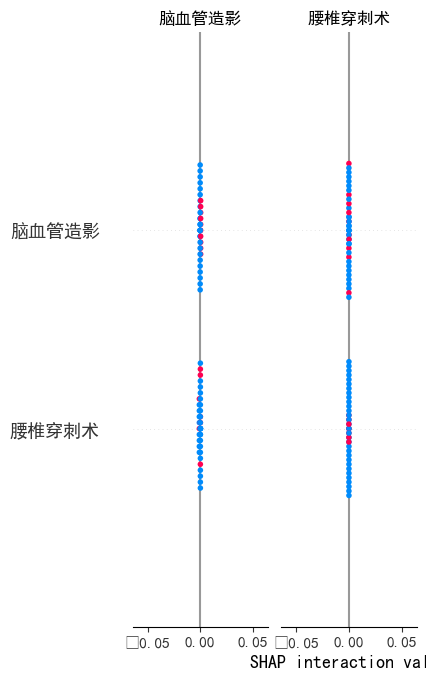

In [21]:
import shap
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)
print()
# 可视化 SHAP 值
shap.summary_plot(shap_values, X_test, feature_names=data_df.columns)
plt.show()

In [22]:
feature_importances = pd.DataFrame(best_rf.feature_importances_, index=data_df.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
feature_importances.index.name = 'Name'
feature_importances= feature_importances.reset_index()
feature_importances

,Name,Importance
0,脑脊液生化(检)-氯[CL]-time-2,0.039014
1,脑脊液生化(检)-氯[CL]-time-1,0.031356
2,脑脊液生化(检)-葡萄糖[Glu]-time-3,0.028502
3,脑脊液常规(检)-白细胞计数-time-0,0.027056
4,脑脊液生化(检)-葡萄糖[Glu]-time-2,0.025686
...,...,...
504,颅骨多发性骨折,0.000000
505,姑息性化疗,0.000000
506,骨继发恶性肿瘤,0.000000
507,手术后切口感染,0.000000


In [23]:
feature_importances.to_csv("outputs/important_feat.csv",index=False)

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

auc_score = roc_auc_score(y_test, y_pred_best_rf)
print(f"AUC Score: {auc_score}")

# 绘制AUC-ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_pred_best_rf)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [39, 38]